In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import SimpleITK as sitk
import itk
from matplotlib import pyplot as plt
import numpy as np
import pydicom
import sys

In [2]:
Dimension = 2
PixelType = itk.ctype('unsigned char')
InputImageType = itk.Image[PixelType, Dimension]

In [3]:
FloatPixelType = itk.ctype('float')
InternalImageType = itk.Image[FloatPixelType,Dimension]

In [29]:
fixed_image_filename =  '/home/tiago/workspace/registration_resources/138_240.png'
moving_image_filename = '/home/tiago/workspace/registration_resources/100_200.png'

In [30]:
fixed_reader = itk.ImageFileReader[InternalImageType].New()
fixed_reader.SetFileName(fixed_image_filename)

moving_reader = itk.ImageFileReader[InternalImageType].New()
moving_reader.SetFileName(moving_image_filename)

fixed_reader.Update()
moving_reader.Update()

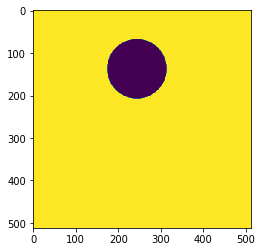

In [31]:
plt.imshow(itk.GetArrayFromImage(fixed_reader.GetOutput()))
plt.show()
                                 

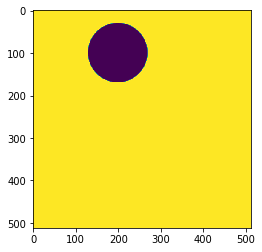

In [32]:
plt.imshow(itk.GetArrayFromImage(moving_reader.GetOutput()))
plt.show()

In [33]:
NormalizerType = itk.NormalizeImageFilter[InternalImageType,InternalImageType]
fixedNormalizer = NormalizerType.New(Input=fixed_reader.GetOutput())

In [34]:
movingNormalizer = itk.NormalizeImageFilter.New(Input=moving_reader.GetOutput())


In [35]:
movingNormalizer.Update()
debug_array = itk.GetArrayFromImage(movingNormalizer.GetOutput())
debug_array.shape
np.amax(debug_array)

0.2504351

In [36]:
#we now will smooth out the images
fixedSmoother = itk.DiscreteGaussianImageFilter.New(Input = fixedNormalizer.GetOutput(),Variance=3.0)

In [37]:
movingSmoother = itk.DiscreteGaussianImageFilter.New(Input = movingNormalizer.GetOutput(),Variance=3.0)

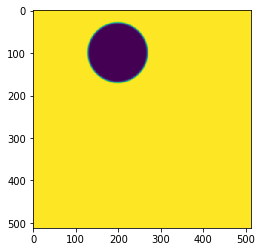

0.2504351


In [38]:
movingSmoother.Update()
plt.imshow(itk.GetArrayFromImage(movingSmoother.GetOutput())*255)
plt.show()
print(np.amax(itk.GetArrayFromImage(movingSmoother.GetOutput())))

In [39]:
movingImage = movingSmoother.GetOutput()
fixedImage  = fixedSmoother.GetOutput()
fixedImage.Update()
movingImage.Update()

In [15]:
#at this point we have 2 images normalized and smoothed to improve the results of the gradient descent. Now we will procceed with the setup of the registration chain

In [40]:
TransformType = itk.Rigid2DTransform
#OptimizerType = itk.RegularStepGradientDescentBaseOptimizer
OptimizerType = itk.RegularStepGradientDescentOptimizerv4
InterpolatorType = itk.LinearInterpolateImageFunction[itk.Image[itk.F,2], itk.D]
MetricType = itk.MattesMutualInformationImageToImageMetric[InternalImageType,InternalImageType]

In [41]:
RegistrationType = itk.ImageRegistrationMethodv4[InternalImageType,InternalImageType]
InitializerType = itk.CenteredTransformInitializer

In [42]:
initializer = InitializerType.New()
transform = TransformType.New()
optimizer = OptimizerType.New()
interpolator = InterpolatorType.New()
registration = RegistrationType.New()

In [43]:
registration.SetFixedImage(fixedImage)
registration.SetMovingImage(movingImage)
registration.SetInitialTransform(transform)
transform.SetIdentity()
registration.SetOptimizer(optimizer)

#registration.Set Interpolator?




In [48]:
registration.Update()

In [49]:
foquinha =registration.GetTransform()

In [50]:
paroco= foquinha.GetParameters()

In [51]:
print(paroco.GetElement(0))
print(paroco.GetElement(1))
print(paroco.GetElement(2))
print(paroco.GetElement(3))

-0.999889090101338
-0.01067455129723506
-0.010385636760492298
4.274e-321


In [20]:
metric = MetricType.New()
registration.SetMetric(metric)
registration.SetFixedImageRegion(fixedImage.GetBufferedRegion())

TypeError: in method 'itkImageRegistrationMethodv4REGv4F2F2_SetMetric', argument 2 of type 'itkObjectToObjectMetricBaseTemplateD *'

In [60]:
initialParameters = transform.GetParameters()
initialParameters.t=0
initialParameters.x=0
initialParameters.y=0
registration.SetInitialTransformParameters(initialParameters)


In [62]:
metric.SetNumberOfHistogramBins(26)
numberOfPixels = fixedImage.GetBufferedRegion().GetNumberOfPixels()
numberOfSamples = numberOfPixels * 0.05
metric.SetNumberOfSpatialSamples(int(numberOfSamples))

In [63]:
optimizer.MinimizeOn()
optimizer.SetMaximumStepLength(0.5)
optimizer.SetMinimumStepLength(0.001)
optimizer.SetNumberOfIterations(1000)


In [69]:
optimizerScales = itk.Array.D()
translationScale = 1.0 /1000.0
optimizerScales.SetSize(3)
optimizerScales[0]=1.0
optimizerScales[1]=1.0
optimizerScales[2]=1.0
#optimizerScales[3]=1.0
#optimizerScales[4] =  translationScale;
#optimizerScales[5] =  translationScale;
optimizer.SetScales(optimizerScales)

In [72]:
finalTransform = TransformType.New()
ResampleFilterType = itk.ResampleImageFilter[InternalImageType,InternalImageType]
resample = ResampleFilterType.New()

In [73]:
resample.SetTransform(finalTransform)
resample.SetInput(movingImage)
resample.SetSize(fixedImage.GetLargestPossibleRegion().GetSize())
resample.SetOutputOrigin(fixedImage.GetOrigin())
resample.SetOutputSpacing(fixedImage.GetSpacing())
resample.SetOutputDirection(fixedImage.GetDirection())
resample.SetDefaultPixelValue(100)

In [74]:
resample.Update()

In [75]:
CheckerBoardFilterType = itk.CheckerBoardImageFilter[InternalImageType]
checkerboard = CheckerBoardFilterType.New()
pattern = itk.Array.UI()
pattern.SetSize(2)

In [76]:
pattern[0]=4
pattern[1]=4
checkerboard.SetCheckerPattern(pattern)
checkerboard.SetInput1(fixedImage)
checkerboard.SetInput2(resample.GetOutput())

In [101]:
FlipFilterType = itk.FlipImageFilter[InternalImageType]
flip = FlipFilterType.New()
flipAxes = itk.FixedArray[itk.B,2]()

flipAxes[0]=True
flipAxes[1]=False
#flipAxes[2]=False

In [102]:
flip.SetFlipAxes(flipAxes)
flip.SetInput(checkerboard.GetOutput())
flip.Update()


In [104]:
import vtk


In [106]:
#ConnectorType  = itk.ImageToImageFilter[InternalImageType]
#connector= ConnectorType.New()
#connector.SetInput(flip.GetOutput())

In [109]:
foca = registration.GetOutput()
foca.Update()

RuntimeError: :0:
This method MUST be overloaded in derived classes

AttributeError: 'itkRegularStepGradientDescentBaseOptimizer' object has no attribute 'Update'